# Test Linear Regression

This notebook is an example that will test the generalization capability of a regression to word vectors. There are three corpora involved.

## Required Data

1. The _word vector corpora_
  * Examples: New York Times, Wikipedia Text8
  * Data: Pretrained word vectors (word2vec, etc.)
2. The _training corpora_
  * Examples: IAPR-TC12, MSCOCO, Visual Genome
  * Data:
    - Training image features and text labels
    - Testing image features and text labels <-- Used as validation data
3. A _testing corpora_ with a different vocabulary
  * Examples: MSCOCO, Visual Genome, etc.
  * Data: Training and testing image features


### Imports

In [1]:
import numpy as np
import matplotlib.pylab as plt
import sys

## Should probably update to PYTHONPATH
sys.path.append('/data/fs4/home/kni/attalos/')
# ls /data/fs4/home/kni/attalos/

## Import word vector load in
import attalos.imgtxt_algorithms.util.readw2v as rw2v

## Import linear regression
import attalos.imgtxt_algorithms.linearregression.LinearRegression as linreg

## Import evaluation code (right now, using Octave soft evaluation)
# from attalos.evaluation.evaluation import Eval
from oct2py import octave
octave.addpath('../evaluation/')

reload(linreg)
%matplotlib inline

### Load the word vectors in

In [2]:
F = rw2v.ReadW2V('linearregression/wordvecs/text9Bvin.bin')
vectors = F.readlines()

### Load training corpora in

In [3]:
data = np.load('linearregression/data/iaprtc_alexfc7.npz')
dTr = open('linearregression/data/iaprtc_dictionary.txt').read().splitlines()
train_ims = [ im.split('/')[-1] for im in open('linearregression/data/iaprtc_trainlist.txt').read().splitlines() ]
xTr = data['xTr'].T
yTr = data['yTr'].T
xTe = data['xTe'].T
yTe = data['yTe'].T

test_ims_full = [ im for im in open('linearregression/data/iaprtc_testlist.txt').read().splitlines() ]
train_ims_full = [ im for im in open('linearregression/data/iaprtc_trainlist.txt').read().splitlines() ]

### Load testing corpora in

In [4]:
imdir = '/data/fs4/teams/attalos/features/image/'
txdir = '/data/fs4/teams/attalos/features/text/'
from attalos.dataset.dataset import Dataset
train_dataset = Dataset(imdir+'visualgenome_train_inception.hdf5', txdir+'visualgenome_train_inception.json.gz')

In [5]:
(x, y) = train_dataset.get_next_batch(100)

### Create probability distribution for words

In [6]:
wordvecs = np.zeros((len(dTr), 200))
for i, word in enumerate(dTr):
    if vectors.has_key( word ):
        wordvecs[i] = vectors[word]
    else:
        print "{}: {}".format(word,i)
        
distvecs = 1 / (1 + np.exp( - 0.01*wordvecs.dot(wordvecs.T) ) )
# distvecs = np.tanh( 0.1*wordvecs.dot(wordvecs.T) )
distvecs = distvecs / np.linalg.norm( distvecs, axis=1 )

bedcover: 15
table-cloth: 259
tee-shirt: 261


### Convert multi-hot vectors to distribution vectors

1. wordvecs -> distvecs
2. onehot -> distvecs

In [7]:
def multi2dist( multihot, distvecs ):
    
    indices = np.where( multihot )[0]
    distvec = np.zeros(len(multihot))
    for i in indices:
        if i not in [15, 259, 261]:
            distvec += distvecs[i]
    return distvec

### Convert all images in the training set to distribution vectors

In [8]:
badims = []
yTarget = np.zeros( (len(yTr), len(dTr)) )
for i in xrange( len(yTr) ):
    distvec = multi2dist( yTr[i], distvecs)
    if not distvec.sum():
        print "Error, there are no tags associated with image "+str(i)
        badims.append(i)
        continue
    yTarget[i] = distvec

for i in badims:
    yTarget = np.concatenate((yTarget[:i,:], yTarget[(i+1):,:]), axis=0)
    xFeats = np.concatenate( (xTr[:i,:], xTr[(i+1):,:]) )

Error, there are no tags associated with image 2868


### Load testing corpora in


-------------------------------

### Train and validate

In [9]:
mp_solution = linreg.LinearRegression(normX = True, normY = True)
mp_solution.train(xFeats, yTarget)
yHat = mp_solution.predict(xTe)

Building W matrix = Y \ X = Y^T X (X X^T)^-1


### Test

### Evaluate the regression

In [10]:
[precision, recall, f1score] = octave.evaluate(yTe.T, yHat.T, 5)
print "P:{},R:{},F1:{}".format(precision,recall,f1score)

P:0.230555649836,R:0.21631169547,F1:0.22320665871


### Visualize

Looking at the 116th image: linearregression/images/02/2779.jpg
Predicted: wall, terrace, tower, building, cobblestone, courtyard, house, cathedral, entrance, ruin, brick, church, city, landscape, paving, monument, skyline, hall, street, ravine, view, mountain, hill, embankment, dome, stone, gate, village, ceiling, corridor, bridge, centre, roof, area, floor, railing, statue, skyscraper, pinnacle, classroom, fountain, valley, balcony, people, park, harbour, jetty, stair, summit, peak, road, seat, column, shelter, terrain, ridge, room, slope, canyon, island, range, tent, river, corner, lookout, grave, bench, middle, writing, country, desk, painting, door, grandstand, stand, ornament, side, coast, formation, tourist, shore, tile, life, court, level, garden, person, restaurant, hut, child, lake, sign, branch, sea, square, one, bedcover, table-cloth, tee-shirt, pillow, lion, leave, pavement, front, couple, glass, lane, trail, stadium, bay, waterfall, dune, forest, spectator, group, salt, d

<Container object of 3 artists>

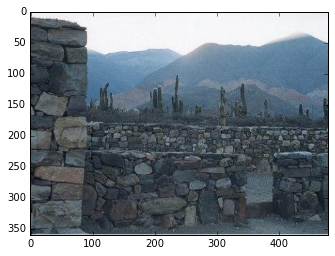

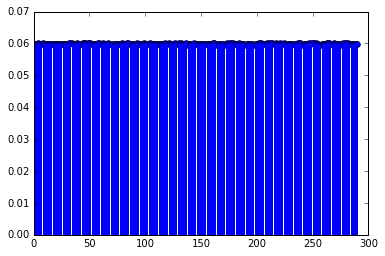

In [11]:
# Randomly select an image
i=np.random.randint(0, yTe.shape[1])

# Run example
imname='linearregression/images/'+test_ims_full[i]+'.jpg';
print "Looking at the "+str(i)+"th image: "+imname
im=plt.imread(imname)

# Prediction
ypwords = [dTr[j] for j in yHat[i].argsort()[::-1] [ 0:(yHat[i]>0.002).sum() ] ]
# Truth
ytwords = [dTr[j] for j in np.where(yTe[i] > 0.5)[0] ]

plt.imshow(im)
print 'Predicted: '+ ', '.join(ypwords)
print 'Truth:     '+ ', '.join(ytwords)

plt.figure()
plt.stem( yHat[i] )